#  Adversarial Attack on MNIST Using JAX

The code that I’m providing has been built upon the following sources:

- https://towardsdatascience.com/creating-adversarial-examples-with-jax-from-the-scratch-bf267757f672
- https://github.com/cleverhans-lab/cleverhans
- https://www.tensorflow.org/tutorials/generative/adversarial_fgsm

CleverHans is a Python library to benchmark machine learning systems' vulnerability to adversarial examples. I highly recommend checking this library. You can learn more about such vulnerabilities on the accompanying blog.

- Adversarial examples: http://karpathy.github.io/2015/03/30/breaking-convnets/
- Adversarial blog: http://www.cleverhans.io/

## This section contains imports and definitions of parameters.

In [1]:
# basic imports
import array
import itertools
import numpy
import numpy.random as npr
import os
import struct

# to download MNIST, unzip and load into memory
import gzip
from os import path
import urllib.request

# JAX is NumPy on the CPU, GPU, and TPU, with great automatic differentiation for high-performance machine learning research.
# Excellent blog to learn more about JAX: https://colinraffel.com/blog/you-don-t-know-jax.html
import jax.numpy as np
from jax.api import grad
from jax.scipy.special import logsumexp
from jax import random
from jax.experimental import optimizers
from jax.experimental import stax

# to visualize results 
import matplotlib.pyplot as plt

# parameters definition
DATA_FOLDER = "/tmp/"
BASE_URL = "https://storage.googleapis.com/cvdf-datasets/mnist/"

## This section downloads, unzips and lods MNIST data.
If you do not know MNIST, check this source: https://en.wikipedia.org/wiki/MNIST_database

In [2]:
def _download_url(url, filename):
  """Download a url to a file in the temp directory."""
  if not path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)
  out_file = path.join(DATA_FOLDER, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print("downloaded {} to {}".format(url, DATA_FOLDER))


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return numpy.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=numpy.float32):
  """Create a one-hot encoding of x of size k."""
  return numpy.array(x[:, None] == numpy.arange(k), dtype)


def mnist_raw():
  """Download and parse the MNIST dataset."""
  
  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return numpy.array(array.array("B", fh.read()), dtype=numpy.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return numpy.array(array.array("B", fh.read()),
                      dtype=numpy.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download_url(BASE_URL + filename, filename)

  train_images = parse_images(path.join(DATA_FOLDER, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(DATA_FOLDER, "train-labels-idx1-ubyte.gz"))

  return train_images, train_labels#, test_images, test_labels


def mnist():
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / numpy.float32(255.)
  train_labels = _one_hot(train_labels, 10)

  return train_images, train_labels


def shape_as_image(images, labels, dummy_dim=False):
  target_shape = (-1, 1, 28, 28, 1) if dummy_dim else (-1, 28, 28, 1)
  return np.reshape(images, target_shape), labels


train_images, train_labels = mnist()  # here starts the execution
num_train = train_images.shape[0]

downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz to /tmp/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz to /tmp/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz to /tmp/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz to /tmp/


## We will create a simple convolutional neural network for predicting classes of handwritten digits. We will adversarially attack this neural network by using fast gradient sign method (FGSM).

Very good blog about this method is available here: https://towardsdatascience.com/perhaps-the-simplest-introduction-of-adversarial-examples-ever-c0839a759b8d

FGSM adds noise (not random noise) whose direction is the same as the gradient of the cost function with respect to the data. The noise is scaled epsilon, which is usually constrained to be a small number via max norm. The magnitude of gradient does not matter in this formula, but the direction (+/-) matters.

$adv\_x = x + \epsilon*\text{sign}(\nabla_xJ(\theta, x, y))$

where

- adv_x : Adversarial image.
- x : Original input image.
- y : Original input label.
- $\epsilon$ : Multiplier to ensure the perturbations are small.
- $\theta$ : Model parameters.
- $J$ : Loss.

The gradients are taken with respect to the input image. This is done because the objective is to create an image that maximises the loss. A method to accomplish this is to find how much each pixel in the image contributes to the loss value. After that, we will add a perturbation accordingly. 

This is fast because it is easy to find how each input pixel contributes to the loss by using the chain rule and finding the required gradients. Hence, the gradients are taken with respect to the image. In addition, since the model is no longer being trained (thus the gradient is not taken with respect to the trainable variables, i.e., the model parameters), and so the model parameters remain constant. The only goal is to fool an already trained model.

The explanation above was taken from here: https://www.tensorflow.org/tutorials/generative/adversarial_fgsm This page also contains an excelent tutorial. The model is MobileNetV2 model, pretrained on ImageNet. 

In [3]:
def predict(params, inputs):
  """We define the function which will compute the output of a fully-connected neural
  network by iterating over all of its layers, taking the activations of the input/previous layer
  and applying the tanh activation."""
  
  activations = inputs
  for w, b in params[:-1]:
    outputs = np.dot(activations, w) + b 
    activations = np.tanh(outputs)

  final_w, final_b = params[-1]
  logits = np.dot(activations, final_w) + final_b
  return logits - logsumexp(logits, axis=1, keepdims=True)

## A fully-connected neural network architecture using ‘stax’ is defined. Stax is experimental sub-library of Jax. Stax is a neural net specification library. 

In [4]:
init_random_params, predict = stax.serial(
    stax.Conv(64, (7,7), padding='SAME'),
    stax.Relu,
    stax.Conv(32, (4, 4), padding='SAME'),
    stax.Relu,
    stax.MaxPool((3, 3)),
    stax.Flatten,
    stax.Dense(128),
    stax.Relu,
    stax.Dense(10),
)

Cross-entropy is a measure of the difference between two probability distributions for a given random variable or set of events. A gentle introduction to cross-entropy are here:

- https://machinelearningmastery.com/cross-entropy-for-machine-learning/
- https://medium.com/data-science-bootcamp/understand-cross-entropy-loss-in-minutes-9fb263caee9a

In [11]:
# loss function for calculating predictions and accuracy before pertubation
def loss(params, batch, test=0):
  inputs, targets = batch
  logits = predict(params, inputs)
  preds  = stax.logsoftmax(logits)

  if test == 1:  # only if we are testing
    print('Prediction vector before softmax')
    print(logits)
    print("____________________________________________________________________________________")
    print('Prediction vector after softmax')
    print(preds)
    print("____________________________________________________________________________________")
  return -(1/(preds.shape[0]))*np.sum(targets*preds)

# loss function for calculating gradients of loss w.r.t. input image
def lo(batch,params):
  inputs, targets = batch
  logits = predict(params, inputs)
  preds  = stax.logsoftmax(logits)
  return -(1/(preds.shape[0]))*np.sum(targets*preds)

In [10]:
# The following function defines the accuracy of our model.
def accuracy(params, batch):
  inputs, targets = batch
  target_class = np.argmax(targets, axis=1)
  predicted_class = np.argmax(predict(params, inputs), axis=1)
  return np.mean(predicted_class == target_class), target_class, predicted_class

# We define a Python generator for our dataset. It outputs one batch of n training examples at a time.

In [12]:
batch_size = 128
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

def data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size:(i + 1) * batch_size]
      yield train_images[batch_idx], train_labels[batch_idx]

batches = data_stream()

## Here we construct optimizer Mini-batch gradient descent optimizer.

Mini-batch gradient descent finally takes the best from Batch gradient descent and Stochastic gradient descent. Recommended blog about these methods is here: https://ruder.io/optimizing-gradient-descent/

opt_init is a pytree representing the initial optimizer state, which includes the initial parameters and may also include auxiliary values like initial momentum.

opt_update is a pytree with the same structure as the `opt_state` argument representing the updated optimizer state.

get_params is as well a pytree representing the parameters extracted from `opt_state`, such that the invariant `params == get_params(init_fun(params))` holds true.

Basically, a method opt_init that takes in a set of initial parameter values returned by init_fun and returns the initial optimizer state opt_state. Method opt_update takes in gradients and parameters and updates the optimizer states by applying one step of optimization, and a method get_params than takes in an optimizer state and return current parameter values.

In [13]:
learning_rate = 0.14
opt_init, opt_update, get_params = optimizers.sgd(learning_rate)

def update(_, i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, grad(loss)(params, batch), opt_state)

## Next, we will train our model on the training examples. At the end of the training, we will obtain the ‘params’ which we are going to use to calculate the gradient of our loss function w.r.t. the test image.

In [14]:
# definitions
num_epochs = 1
key = random.PRNGKey(123)
_, init_params = init_random_params(key, (-1, 28, 28, 1))

In [15]:
# training part
opt_state = opt_init(init_params)
itercount = itertools.count()

for i in range(num_batches):
  if i % 25 == 0: print('Computing batch {:}/{:}'.format(i, num_batches))
  opt_state= update(key, next(itercount), opt_state, shape_as_image(*next(batches)))

params = get_params(opt_state)
print("Finished")

Computing batch 0/469
Computing batch 25/469
Computing batch 50/469
Computing batch 75/469
Computing batch 100/469
Computing batch 125/469
Computing batch 150/469
Computing batch 175/469
Computing batch 200/469
Computing batch 225/469
Computing batch 250/469
Computing batch 275/469
Computing batch 300/469
Computing batch 325/469
Computing batch 350/469
Computing batch 375/469
Computing batch 400/469
Computing batch 425/469
Computing batch 450/469
Finished


We define the function which will return us the gradient of the loss function w.r.t the test input. This function will calculate test loss as well as predict the class of our target variable. 

This is pretty straightforward. First line calculates test accuracy. Second line calculates test loss. Third lines calculates the gradients, which are also returned.

In [16]:
def covnet(user_run, params):
  # user_run: this function was executed by user and it will print additional information.
  test_acc,target_class, predicted_class = accuracy(params, shape_as_image(test_images, test_labels))
  test_loss = loss(params, shape_as_image(test_images, test_labels), test=user_run)
  grads = grad(lo)(shape_as_image(test_images, test_labels), params)

  if user_run == 1:
      print('Test accuracy (%): {:.2f}'.format(100 * test_acc))
      print('Test loss (%): {:.2f}'.format(test_loss))
      print('Predicted class: ', predicted_class)
      print('Target class:', target_class)
  return grads, test_acc

# We are near the end. We choose an image which belongs to the class ‘8’ and display it.

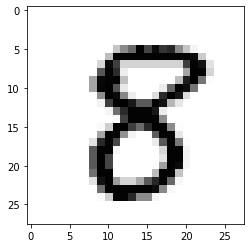

In [17]:
selected_image = 333

# Function to display image
def display(image):
  img = image.reshape((28,28))
  plt.imshow(img, cmap="Greys")
  plt.show()
  return

display(train_images[selected_image])

In next cell, we load the image and test, what are model predicts. If we did everything right, predicted class should be '8'. Bear in mind, that we are testing an image, which the model was trained on, but for our purpose, it does not matter.

In [18]:
def load_img(image,img_label):
  img = np.array(image)
  img = img.reshape(1,784)
  label = np.array(img_label)
  label = label.reshape(1,10)
  return img, label

img, label = load_img(train_images[selected_image],train_labels[selected_image])  
test_images = img
test_labels = label

# predictions before pertubation 
grads, acc = covnet(1, params)

Prediction vector before softmax
[[ 3.387504   -4.2424345   5.5979037  -0.44558826 -4.4707594   2.9573107
   3.8999696  -4.927149   18.507484    0.27495083]]
____________________________________________________________________________________
Prediction vector after softmax
[[-1.5119983e+01 -2.2749924e+01 -1.2909583e+01 -1.8953077e+01
  -2.2978249e+01 -1.5550177e+01 -1.4607518e+01 -2.3434637e+01
  -3.3378547e-06 -1.8232538e+01]]
____________________________________________________________________________________
Test accuracy (%): 100.00
Test loss (%): 0.00
Predicted class:  [8]
Target class: [8]


Let’s perturb the same image with fast gradient sign method. For this purpose, we have defined the function bellow. Here we are using 0.3 as the value of epsilon. Additionaly, lets display the image.

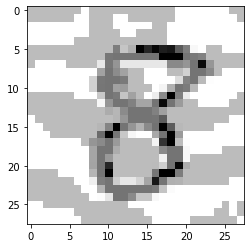

In [19]:
epsilon = 0.3

def perturb(grad, img, epsilon):
  grads = grad[0]
  a = numpy.reshape(grads, (1, 784))
  s = np.sign(a)
  perturbed_image = img + np.dot(epsilon,s)
  return perturbed_image

adversarial_img = perturb(grads, train_images[selected_image], epsilon)
display(adversarial_img)

And the last step, show that are perturbed / adversarial image is clearly of class '8', but our neural network is showing class '2'. 

This approach is applicable also to a more complex datasets than MNIST.

In [20]:
img, label = load_img(adversarial_img, train_labels[selected_image])  
test_images = img
test_labels = label

grads, acc = covnet(1,params)

Prediction vector before softmax
[[ 1.3961667 -1.5118341 10.725666  -1.465681  -1.659752  -3.4278665
   2.1676345  3.5835493  4.9841194 -0.6741743]]
____________________________________________________________________________________
Prediction vector after softmax
[[-9.3337975e+00 -1.2241798e+01 -4.2984951e-03 -1.2195645e+01
  -1.2389716e+01 -1.4157830e+01 -8.5623293e+00 -7.1464152e+00
  -5.7458453e+00 -1.1404139e+01]]
____________________________________________________________________________________
Test accuracy (%): 0.00
Test loss (%): 5.75
Predicted class:  [2]
Target class: [8]
